In this notebook we learn a neural network instead.

We first import and clean the data.

In [1]:
from fastai.tabular.all import *

comp = 'bluebook-for-bulldozers'
path = URLs.path(comp)

Path.BASE_PATH = path

df = pd.read_csv(path/'TrainAndValid.csv', engine='pyarrow', dtype=object).convert_dtypes(convert_string=False)
for colname, col_dtype in df.dtypes.items():
    if col_dtype != np.dtype('O'):
        continue
    df.loc[df[colname] == '', colname] = np.nan
df['SalePrice'] = df['SalePrice'].astype(np.float64)

sizes = 'Large', 'Large / Medium', 'Medium', 'Small', 'Mini', 'Compact'
df['ProductSize'] = df['ProductSize'].astype('category')
df['ProductSize'].cat.set_categories(sizes, ordered=True)

dep_var = 'SalePrice'
df[dep_var] = np.log(df[dep_var])

df['saledate'] = pd.to_datetime(df['saledate'], format='%m/%d/%Y 0:00')

df = add_datepart(df, 'saledate')
' '.join(o for o in df.columns if o.startswith('sale'))

cond = (df.saleYear < 2011) | (df.saleMonth < 10)
train_idx = np.where(cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx), list(valid_idx))

We also use the insight obtained in the previous notebook to remove unnecessary columns.

In [2]:
xs_final_time = load_pickle(path/'xs_final_time.pkl')
df_nn_final = df[list(xs_final_time.columns) + [dep_var]]

We do the continuous/categorical split here.

In [3]:
cont_nn, cat_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var=dep_var)

We verify that `saleElapsed` is continuous, since we want our model to be able to extrapolate on it.

In [4]:
cont_nn

['saleElapsed']

And look at the cardinality of each categorical variable.

In [5]:
df_nn_final[cat_nn].nunique()

YearMade                73
Coupler_System           2
ProductSize              6
fiProductClassDesc      74
ModelID               5281
fiSecondaryDesc        177
Enclosure                6
fiModelDesc           5059
fiModelDescriptor      140
saleYear                24
ProductGroup             6
Drive_System             4
Tire_Size               17
Hydraulics              12
Track_Type               2
dtype: int64

In [6]:
to_eval1 = TabularPandas(df_nn_final, [Categorify, FillMissing], cat_nn, cont_nn, y_names=dep_var, splits=splits)
df_eval2 = df_nn_final.loc[:, df_nn_final.columns != 'fiModelDescriptor']
to_eval2 = TabularPandas(df_eval2, [Categorify, FillMissing], [cat for cat in cat_nn if cat != 'fiModelDescriptor'], cont_nn, y_names=dep_var, splits=splits)

For the sake of model size, we would like to see if we can omit one of the the high-cardinality categorical variables. We evaluate how important they are with the loss on random forests. For convenience, we use the datasets we had used in the previous notebook, that is already split into training and validation.

In [7]:
from sklearn.ensemble import RandomForestRegressor

def rf(xs, y, n_estimators=40, max_samples=200_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

def r_mse(x, y):
    return round(math.sqrt(((x - y)**2).mean()), 6)

m = rf(to_eval1.train.xs, to_eval1.train.y)
m2 = rf(to_eval2.train.xs, to_eval2.train.y)
r_mse(m.predict(to_eval1.train.xs), to_eval1.train.y), r_mse(m.predict(to_eval1.valid.xs), to_eval1.valid.y), r_mse(m2.predict(to_eval2.train.xs), to_eval2.train.y), r_mse(m2.predict(to_eval2.valid.xs), to_eval2.valid.y)

(0.188815, 0.230454, 0.190582, 0.231908)

We judge that we find this change in loss acceptable, and drop the column.

In [8]:
cat_nn.remove('fiModelDescriptor')

In [9]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)

Tabular models and data don't generally require much GPU RAM, so we can use larger batch sizes:

In [10]:
dls = to_nn.dataloaders()

We set a `y_range` for our regression, and in this case we infer them from the bounds in the training set.

In [11]:
y = to_nn.train.y
y.min(), y.max()

(np.float32(8.465899), np.float32(11.863583))

We define the model and learner.

In [12]:
learn = tabular_learner(dls, y_range=(8, 12), layers=[500, 250],
                        n_out=1, loss_func=F.mse_loss)

And find a good learning rate.

SuggestedLRs(valley=0.0003311311302240938)

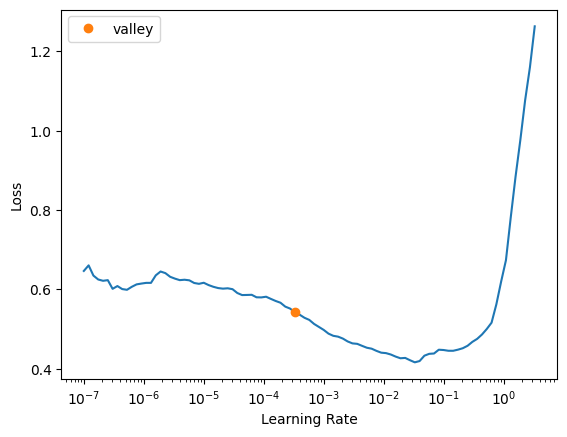

In [13]:
learn.lr_find()

There's no need to use `fine_tune`, so we'll train with `fit_one_cycle` for a few epochs and see how it looks:

In [14]:
learn.fit_one_cycle(8, 5e-2)

epoch,train_loss,valid_loss,time
0,0.071367,0.064037,01:11
1,0.079698,0.067263,01:05
2,0.080310,0.066555,01:08
3,0.065494,0.061864,01:07
4,0.060035,0.075381,01:05
5,0.058461,0.059170,01:05
6,0.051377,0.055639,01:05
7,0.050431,0.052432,01:04


In [15]:
preds, targs = learn.get_preds()
r_mse(preds,targs)

0.228981

In [16]:
learn.save('nn')

Path('models/nn.pth')

Finally, we consider a half-half ensemble.

In [17]:
rf_preds = m2.predict(to_eval2.valid.xs)

In [18]:

ens_preds = (to_np(preds.squeeze()) + rf_preds) /2

In [19]:
r_mse(ens_preds, to_eval2.valid.y)

0.224031